**Unsupervised Anomaly Detection with VAE**
====== 
*Notebook created in PyTorch by Mariona Carós for the UPC School (2021)*

### **Goal**
In this colab, you're going to train a Variational Autoencoder (VAE) to detect tumors from brain Magnetic resonance images (MRI). 


### **Getting Started**
You will begin by importing some useful packages and the dataset you will use to build and train your VAE. Don't forget to set GPU as your hardware accelerator in `Runtime > Change runtime type > Hardware Accelerator`

In [ ]:
!pip install gdown
import sys
import numpy as np
import pandas as pd
import os
import torch
import gdown
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from skimage.util import random_noise
import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.manual_seed(10) 
plt.rcParams["figure.figsize"] = (4,4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


**Defining the Hyperparameters**


In [ ]:
hparams = {
          'latent_dims':3,
          'num_epochs':50,
          'batch_size':64,
          'channels':128,
          'learning_rate':1e-4,
          'variational_beta':1,
          'weight_decay':1e-5,
          'use_gpu':True
}

# 1.Dataset
We are going to use a public [dataset from  Kaggle](https://www.kaggle.com/c/1056lab-brain-cancer-classification/data). The first things you need to do is to downlaod the dataset. Then, you can plot the images to see  how they look like and check the amount of brain MRI samples that we have.

In [ ]:
# if you need to remove all files use this
!rm -rf *

In [ ]:
# Download dataset
!gdown --id 1ApHQyJnMauNb0GhySwCc8-1mUudJx6nl
!gdown --id 14jvqTMHX6MDu7lXh3Lkssw0lEajmxrSq
!unzip -qq dataset_no_tumor.zip
!unzip -qq dataset_tumor.zip

In [ ]:
# get paths of images
paths_healthy_brain = glob.glob('/content/no_tumor/*.jp*')
paths_tumor = glob.glob('/content/tumor/*.jp*')

# plots of paths_healthy_brain
fig, axs = plt.subplots(1, 5, figsize=[20, 5])
for ix in range(5):
  img = cv2.imread(paths_healthy_brain[ix], 0) # 0 for grayscale
  axs[ix].imshow(img, cmap='gray')
print('Brains without tumor')


In [ ]:
# plots of paths_tumor
fig, axs = plt.subplots(1, 5, figsize=[20, 5])
for ix in range(5):
  img = cv2.imread(paths_tumor[ix], 0) # 0 for grayscale
  axs[ix].imshow(img, cmap='gray')
print('Brains with tumor')


In [ ]:
print('Number of helthy RMI brain images: ', len(paths_healthy_brain))
print('Number of RMI brain images with tumor: ', len(paths_tumor))

We have very few samples to train a model... You will need to think a way of increasing the number of training samples. So, we are going to split our dataset into train and test and try to enlarge our training samples.

In [ ]:
paths_train = paths_healthy_brain[10:]
paths_test_health = paths_healthy_brain[:10]  # we keep 10 samples for testing our model
paths_test_tumor = paths_tumor


## Data Augmentation
To get more data, we just need to make minor alterations to our existing dataset. There are many techniques to do so! Such as flips, translations, rotations or adding noise. 

Start by using the function `cv2.imread(filename, flags)` to read an image, where the full path of the image should be given in *filename*. The second argument is a flag which specifies the way image should be read (0 for grayscale images)

Use the following functions to flip your training images:

- Flip array in the left/right direction:  `numpy.fliplr(m)`
- Flip array in the up/down direction:  `numpy.flipud(m)`




In [ ]:
# Flip all training images

for i, path in enumerate(paths_train):
  # TODO: Flip images for data augmentation
  image = ...
  flipLR = ...
  flipUD = ...

  cv2.imwrite('/content/no_tumor/flipLR'+str(i)+'.jpg', flipLR) 
  cv2.imwrite('/content/no_tumor/flipUD'+str(i)+'.jpg', flipUD) 


Now we are going to double the amount of images by adding gaussian noise! 

- We will use `random_noise(image, mode='gaussian', var=sigma**2)` function. 
- The sigma value is your choice. Check `0.001, 0.05`, and `0.2` and use the value that you think is the best. 


Be carefull because if you add too much noise, we would loss important details of the brain MRI that would be usefull to detect tumors.

You can try the values of sigma by running the following cell of code.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[10, 6])
# plot original image
img = img = cv2.imread(paths_healthy_brain[3], 0)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

# TODO: standard deviation for noise to be added in the image
sigma = ...

noisyRandom = random_noise(img,  mode='gaussian',var=sigma**2)
axs[1].imshow(noisyRandom, cmap='gray')
axs[1].set_title('Noise added')
plt.show()


Store noisy samples in directory with the chosen sigma


In [ ]:
# Add noise to all the training images
for i, path in enumerate(glob.glob('/content/no_tumor/*.jpg')):
  img = cv2.imread(path, 0)
  noisyRandom = random_noise(img, mode='gaussian',var=sigma**2)
  noisyRandom = 255 * (noisyRandom - noisyRandom.min()) / (noisyRandom.max() - noisyRandom.min())
  noisyRandom = np.array(noisyRandom, np.int)

  cv2.imwrite('/content/no_tumor/noisy'+str(i)+'.jpg', noisyRandom)


The following cell gives us the amount of **training samples**

In [ ]:
! ls /content/no_tumor/*jpg | wc -l 

We use a customized dataset class to resize and normalize the samples before passing  them to the model. 

In [ ]:

class Dataset_brain_mri:

    def __init__(self, data_list):
        self.list_img = data_list

    def __len__(self):
        return len(self.list_img)

    # when the sample corresponding to a given index is called, the generator executes __getitem__ to generate it
    def __getitem__(self, index):
        """Generates one sample of data"""
        # Select sample
        img_path = self.list_img[index]
        img = cv2.imread(img_path, 0) # 0 for grayscale
        # resize image
        img = cv2.resize(img, (64,64))
        output = img/255.

        sample = {'img':output, 'path':img_path}
        return sample

We define Dataset and Dataloader generators and convert data into Torch tensors.

In [ ]:
def batchify(batch):
    '''batch will contain a list of imsi_matrix'''

    # Converting the data into Torch tensors
    batch_data = torch.stack([torch.FloatTensor(i['img']) for i in batch])  # transform to torch tensors
    batch_paths = [i['path'] for i in batch]  # path

    return batch_data, batch_paths

In [ ]:

paths_train = glob.glob('/content/no_tumor/*.jpg')
training_set = Dataset_brain_mri(paths_train)
train_dataloader = DataLoader(training_set, 
                              batch_size=hparams['batch_size'], 
                              collate_fn=batchify, 
                              shuffle=True, 
                              drop_last=True)

testing_set_tumor = Dataset_brain_mri(paths_test_tumor[:20])
testing_set_health = Dataset_brain_mri(paths_test_health)

test_set = ConcatDataset([testing_set_health, testing_set_tumor])
test_dataloader = DataLoader(test_set, 
                             batch_size=1, 
                             collate_fn=batchify, 
                             shuffle=False,  
                             drop_last=False)


# 2.VAE Definition
We will be using deep convolutional neural networks (CNNs) for the encoder and decoder as they are the NN that usually perform better with images. You also can find batch normalization, ReLU activation functions and max pooling layers.

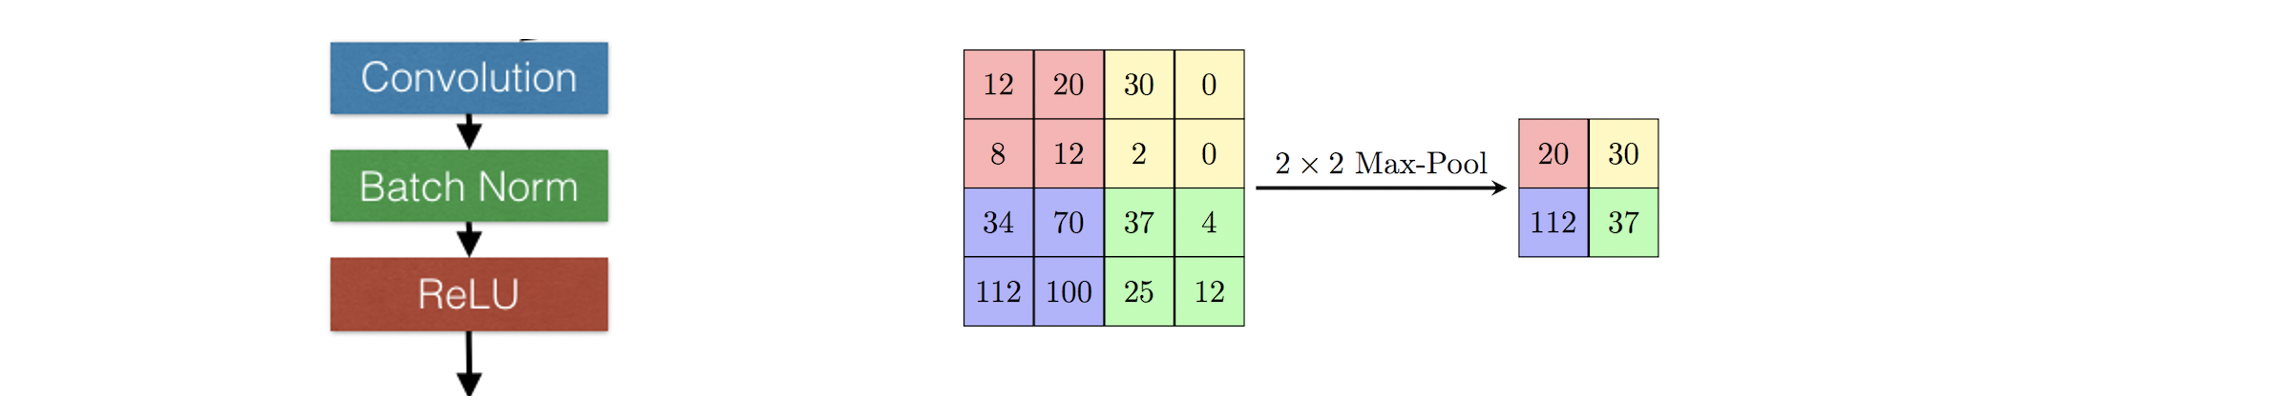
You are given the encoder class, but you need to complete the forward function of the decoder.  


*Hints*:

*   *MaxUnpool2d* takes in as input the **output of MaxPool2d** **including the indices** of the maximal values and computes a partial inverse in which all non-maximal values are set to zero.
```
#Example:
output, indices = pool(input)
input_unpool = unpool(output, indices)
```

*  You should use this activation function in the last layer as we want our output to be between 0 and 1 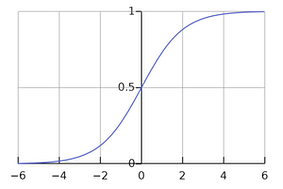




In [ ]:
class Encoder(nn.Module):
    def __init__(self, channels,latent_dims):
        super(Encoder, self).__init__()
        self.c = channels
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=channels, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1) # out: c x 32 x 32
        self.batchnorm1 = nn.BatchNorm2d(channels)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # RELU Activation

        self.conv2 = nn.Conv2d(in_channels=channels, 
                               out_channels=channels*2, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1) # out: c x 2 x 16 x 16
        self.batchnorm2 = nn.BatchNorm2d(channels*2)  
        self.maxpool = nn.MaxPool2d(kernel_size=3, 
                                    stride=1, 
                                    padding=0, 
                                    return_indices=True, 
                                    ceil_mode=False )  # out: c x 2 x 14 x 14

        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*4, 
                               kernel_size=3, stride=2, padding=0) # out: c x 4 x 6 x 6
        self.batchnorm3 = nn.BatchNorm2d(channels*4) 

        self.fc_mu = nn.Linear(in_features=self.c*4*6*6, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=self.c*4*6*6, out_features=latent_dims)

    def forward(self, x):
        out = self.relu(self.batchnorm1(self.conv1(x)))
        out = self.relu(self.batchnorm2(self.conv2(out)))
        out, ix = self.maxpool(out)
        out = self.relu(self.batchnorm3(self.conv3(out)))

        out = out.view(out.size(0), -1) # flatten batch 
        x_mu = self.fc_mu(out)  # shape [batch_size, latent_dims]
        x_logvar = self.fc_logvar(out) # shape [batch_size, latent_dims]

        return x_mu, x_logvar, ix


class Decoder(nn.Module):
    def __init__(self, channels, latent_dims):
        super(Decoder, self).__init__()
        self.c = channels
        self.fc = nn.Linear(in_features=latent_dims, out_features=self.c*4*6*6)
        
        self.conv3 = nn.ConvTranspose2d(in_channels=self.c*4, 
                                        out_channels=self.c*2, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=0)
        self.batchnorm3 = nn.BatchNorm2d(channels*2)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # RELU Activation

        self.unpool = nn.MaxUnpool2d(kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.ConvTranspose2d(in_channels=self.c*2, 
                                        out_channels=self.c, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.batchnorm2 = nn.BatchNorm2d(channels)
        self.conv1 = nn.ConvTranspose2d(in_channels=self.c, 
                                        out_channels=1, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)

    def forward(self, z, ix):
        # TODO
        # Hint: Remember to unflatten batch of feature vectors to use CNNs 
        # input shape of CNNs should be: (batch, channels, height, width)
        out = ...
        out = ...
        out = ...
        out = ...
        out = ...
        out = ...

        return out


The overall architecture is then obtained by concatenating the encoder and the decoder parts, making the gradient descent possible by using the reparametrization trick, using the fact that if z is a random variable following a Gaussian distribution with mean $\mu$ and with covariance $\Sigma$ then it can be expressed as: 
$$z=\Sigma \epsilon + \mu$$   $$\epsilon \sim N(0,I)$$

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, z_dims, n_ch):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(channels=n_ch,latent_dims=z_dims)
        self.decoder = Decoder(channels=n_ch, latent_dims=z_dims)
    
    def reparametrize(self, mu, logvar):
        # Given mean and logvar returns z
        std = torch.exp(0.5 * logvar)
        # Random sample
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        latent_mu, latent_logvar, ix = self.encoder(x)
        z = self.reparametrize(latent_mu, latent_logvar)
        x_recon = self.decoder(z, ix)
        return x_recon, latent_mu, latent_logvar


## Loss Function

The loss function that is minimised when training a VAE is composed of a reconstruction term , that tends to make the output as similar as possible to the input, and a regularisation term, that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. 

The mathematical notation for the lower bound you want to maximize is: $\mathbb{E}\left(\log p(x|z)\right) - \mathrm{D_{KL}}(q(z|x)\Vert p(z))$

**Reconstruction Loss: Binary Cross Entropy** 

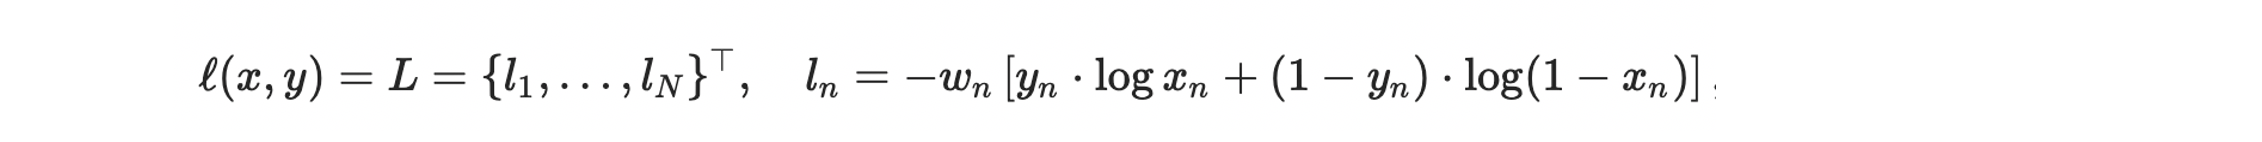

**Regularisation: KL Divergence**

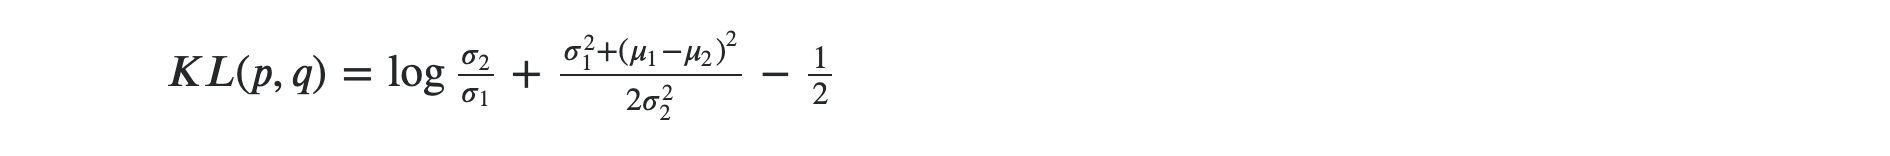





In [ ]:
def vae_loss(recon_x, x, mu, logvar, variational_beta=1):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    kld = variational_beta * KL_divergence(mu, logvar) / x.shape[0]
    return recon_loss, kld

def KL_divergence(mu, logvar):
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return kldivergence


# 3.Training


Now, you can start training your model!

In [ ]:
# Instantiate optimizer and model here
vae = VariationalAutoencoder(hparams['latent_dims'], hparams['channels'])
optimizer = torch.optim.Adam(params=vae.parameters(), 
                             lr=hparams['learning_rate'], 
                             weight_decay=1e-5)

# Move model to the GPU
print(device)
vae = vae.to(device)

# This is the number of parameters used in the model
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

# set to training mode
vae.train()

train_loss_avg = []
bce_loss_avg = []
kld_loss_avg = []
b_since_improvement=0
best_loss = np.inf

print('Training ...')
for epoch in range(hparams['num_epochs']):
  train_loss_avg.append(0)
  bce_loss_avg.append(0)
  kld_loss_avg.append(0)
  num_batches = 0
    
  for i, (image_batch, batch_paths) in enumerate(train_dataloader):
      image_batch.unsqueeze_(1) # [batch_size, 1, 64, 64] 
      image_batch = image_batch.to(device)

      # get vae reconstruction
      image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
      # get loss
      bce, kld = vae_loss(image_batch_recon, image_batch, latent_mu, 
                          latent_logvar)
      loss=bce+kld

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      
      # one step of the optmizer (using the gradients from backpropagation)
      optimizer.step()
      
  train_loss_avg[-1] += loss.item()
  bce_loss_avg[-1] += bce.item()
  kld_loss_avg[-1] += kld.item()
  num_batches += 1

  print('Epoch [%d / %d] average reconstruction error: %f' 
        % (epoch+1, hparams['num_epochs'], train_loss_avg[-1]))

Run the code to check how the training loss changes with every iteration over the dataset.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[20, 4])

axs[0].plot(kld_loss_avg)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('KLD Loss')

axs[1].plot(bce_loss_avg)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('BCE Loss')

axs[2].plot(train_loss_avg)
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_title('Training Loss (BCE + KLD)')
plt.show()

### Evaluate on the Test Set
Complete the evaluation loop with your VAE and loss to evaluate the model on the test set.

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=[20, 4])

# set to evaluation mode
vae.eval()

test_loss_avg = 0
for i, sample in enumerate(test_dataloader):
    
    with torch.no_grad():
        img_test = sample[0].unsqueeze_(1).to(device)
        
        # TODO: get vae reconstruction and loss
        ...
        ...
        ...

        if i < 10:
          # plot images
          axs[0, i].imshow(img_test.cpu().view(64,64), cmap='gray')
          axs[0, i].set_title('BCE loss: '+ str(round(bce.item(),2)))
          axs[1, i].imshow(img_test_recon.cpu().view(64,64), cmap='gray')

        test_loss_avg += bce.item()

test_loss_avg /= i
print('average reconstruction error: %f' % (test_loss_avg))

# 4.Anomaly Detection

Our goal is to obtain a **ranked list of anomalies**, where topmost samples in the list correspond to detected anomalies.

An anomaly is an observation which deviates so much from other observations as to arouse suspicions that it was generated by a different mechanism.

We will use **KLD** as our **anomaly metric**, which corresponds to the **difference between the learned latent space** and the **Gaussian** distribution. Being zero if the compared distributions are identical, and greater than zero depending on how much differ the distributions. The higher the KLD score, the more probable of being an anomaly.

**Compute the KLD for every sample of the test dataset and set a threshold** to define up to which value a sample should be considered an anomaly.

In [ ]:
dic = {'brain MRI': [], 'KLD': []}

for i, (sample, path) in enumerate(test_dataloader):
      dic['brain MRI'].append(path[0])
      mri_img = sample.unsqueeze_(1).to(device)
      
      # TODO
      latent_mu, latent_logvar, ix = ...
      kld = ...

df = pd.DataFrame(dic, columns = ['brain MRI', 'KLD'])
df = df.sort_values('KLD', ascending=False)
df

In [ ]:
# TODO: Define a threshold
THRESHOLD = ...

df.style.apply(lambda x: ["background: yellow" if v > THRESHOLD else "" for v in df['KLD']], axis = 0)


### MRI test samples detected as tumors

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=[30, 5])

i=0  # counter
tp=0  # true positives
fp=0  # false positives

print('Detected MRI brains with tumor:')
for path, score in zip(df['brain MRI'], df['KLD']):
    if score >= THRESHOLD :
        img = cv2.imread(path, 0)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title('kld: '+ str(round(score,2))+ ' label: '+str(path[9:14]))
        i+=1
        if '/tumor' in path:
          tp+=1
        if '/no_tumor' in path:
          fp+=1
    if i == 10:
        break

### MRI samples detected as no-tumor

In [ ]:
fig, axs = plt.subplots(1, len(df[df.KLD<THRESHOLD]), figsize=[30, 5])

i=0
fn=0  # false negatives

print('Not detected as tumor')
for path, score in zip(df['brain MRI'], df['KLD']):
    if score < THRESHOLD:
        img = cv2.imread(path, 0)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title('kld: '+ str(round(score,2))+ ' label: '+str(path[9:17]))
        i+=1
        if '/tumor' in path:
          fn+=1


### Performance Metrics

In [ ]:
print('Precision(%): ',(tp/(tp+fp))*100)

In [ ]:
print('Recall(%): ',(tp/(tp+fn))*100)


### Missed Positives

In [ ]:

i=0
for path, score in zip(df['brain MRI'], df['KLD']):
    if score < THRESHOLD and '/tumor' in path:
        img = cv2.imread(path, 0)
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title('You missed this MRI with tumor! KLD='+ str(round(score,2))
                  + ' label: '+str(path[9:17]))
        plt.show()
        i+=1
if i == 0:
  print('Congrats! 0 missed brain MRI with tumor!')